In [1]:
# ==============================================
# 1. Import Libraries
# ==============================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy.stats import linregress
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ==============================================
# 2. Define State Abbreviation Mapping
# ==============================================

# Mapping of state abbreviations to full state names in lowercase
state_abbrev_to_name = {
    'al': 'alabama', 'ak': 'alaska', 'az': 'arizona', 'ar': 'arkansas',
    'ca': 'california', 'co': 'colorado', 'ct': 'connecticut', 'de': 'delaware',
    'fl': 'florida', 'ga': 'georgia', 'hi': 'hawaii', 'id': 'idaho',
    'il': 'illinois', 'in': 'indiana', 'ia': 'iowa', 'ks': 'kansas',
    'ky': 'kentucky', 'la': 'louisiana', 'me': 'maine', 'md': 'maryland',
    'ma': 'massachusetts', 'mi': 'michigan', 'mn': 'minnesota', 'ms': 'mississippi',
    'mo': 'missouri', 'mt': 'montana', 'ne': 'nebraska', 'nv': 'nevada',
    'nh': 'new hampshire', 'nj': 'new jersey', 'nm': 'new mexico', 'ny': 'new york',
    'nc': 'north carolina', 'nd': 'north dakota', 'oh': 'ohio', 'ok': 'oklahoma',
    'or': 'oregon', 'pa': 'pennsylvania', 'ri': 'rhode island', 'sc': 'south carolina',
    'sd': 'south dakota', 'tn': 'tennessee', 'tx': 'texas', 'ut': 'utah',
    'vt': 'vermont', 'va': 'virginia', 'wa': 'washington', 'wv': 'west virginia',
    'wi': 'wisconsin', 'wy': 'wyoming', 'dc': 'district of columbia',
    'as': 'american samoa', 'gu': 'guam', 'mp': 'northern mariana islands',
    'pr': 'puerto rico', 'vi': 'virgin islands', 'us': 'united states'
}

# Define territories and non-continental states to exclude
exclude_states = [
    'puerto rico', 'guam', 'virgin islands', 'american samoa',
    'northern mariana islands', 'alaska', 'hawaii', 'united states'
]

exclude_states_lower = [state.lower() for state in exclude_states]


In [5]:
# ==============================================
# 3. Load and Process Cargo Fraud Data
# ==============================================

# Load the cargo fraud data
cargo_fraud = pd.read_csv('cargo_fraud_only.csv')

# Check if 'data_year' column exists
if 'data_year' in cargo_fraud.columns:
    # Use 'data_year' as 'Year'
    cargo_fraud['Year'] = cargo_fraud['data_year'].astype(int)
else:
    # Extract 'Year' from 'date_recovered' or another date column
    cargo_fraud['date_recovered'] = pd.to_datetime(cargo_fraud['date_recovered'], errors='coerce')
    cargo_fraud['Year'] = cargo_fraud['date_recovered'].dt.year
    cargo_fraud = cargo_fraud.dropna(subset=['Year'])
    cargo_fraud['Year'] = cargo_fraud['Year'].astype(int)

# Ensure the 'State' column exists and matches the 'State' in other datasets
if 'state_name' in cargo_fraud.columns:
    cargo_fraud['State'] = cargo_fraud['state_name'].str.lower().str.strip()
elif 'state_abbr' in cargo_fraud.columns:
    # Map state abbreviations to full state names
    cargo_fraud['State'] = cargo_fraud['state_abbr'].str.lower().map(state_abbrev_to_name)
else:
    raise KeyError("No 'state_name' or 'state_abbr' column found in cargo_fraud DataFrame.")

# Exclude rows with missing 'State' or 'Year'
cargo_fraud = cargo_fraud.dropna(subset=['State', 'Year'])

# Exclude territories and non-continental states
cargo_fraud = cargo_fraud[~cargo_fraud['State'].isin(exclude_states_lower)]

# Display the processed cargo fraud data
print("\nProcessed Cargo Fraud Data:")
print(cargo_fraud[['State', 'Year']].head())


Processed Cargo Fraud Data:
     State  Year
0  florida  2012
1  florida  2012
2  florida  2012
3  florida  2012
4  florida  2012


In [7]:
# ==============================================
# 4. Load and Process HPI Data
# ==============================================

# Load HPI data
hpi_data_url = "https://raw.githubusercontent.com/ryantangmj/ryantangmj.github.io/main/hpi_by_state.csv"
hpi_data = pd.read_csv(hpi_data_url)

# Keep relevant columns
hpi_data = hpi_data[["State", "Year", "HPI"]]

# Filter years between 2012 and 2022
hpi_data = hpi_data[(hpi_data["Year"] >= 2012) & (hpi_data["Year"] <= 2022)].reset_index(drop=True)

# Standardize 'State' names
hpi_data['State'] = hpi_data['State'].str.lower().str.strip()

# Map state abbreviations to full names if necessary
if hpi_data['State'].str.len().max() == 2:
    hpi_data['State'] = hpi_data['State'].map(state_abbrev_to_name)

# Exclude territories and non-continental states
hpi_data = hpi_data[~hpi_data['State'].isin(exclude_states_lower)]

# Convert 'Year' to integer
hpi_data['Year'] = hpi_data['Year'].astype(int)

# Display the first few rows
print("\nProcessed HPI Data:")
print(hpi_data.head())



Processed HPI Data:
     State  Year     HPI
0  alabama  2012  341.58
1  alabama  2013  339.66
2  alabama  2014  344.12
3  alabama  2015  352.11
4  alabama  2016  361.39


In [9]:
# ==============================================
# 5. Load and Process Poverty Data
# ==============================================

# Load poverty data
poverty_data = pd.read_csv('poverty_data.csv')  # Replace with the actual file path

# Reshape poverty data to long format
id_vars = ['State']
value_vars = [col for col in poverty_data.columns if col != 'State']

poverty_long = pd.melt(poverty_data, id_vars=id_vars, value_vars=value_vars,
                       var_name='Variable', value_name='Value')

# Extract 'Year' from the 'Variable' column
poverty_long['Year'] = poverty_long['Variable'].str.extract('(\d{4})', expand=False).astype(int)
poverty_long['Variable_Name'] = poverty_long['Variable'].str.replace(' \d{4}', '', regex=True).str.strip()

# Pivot the data to have one row per 'State' and 'Year'
poverty_pivot = poverty_long.pivot_table(index=['State', 'Year'], columns='Variable_Name', values='Value', aggfunc='first').reset_index()
poverty_pivot.columns.name = None

# Standardize 'State' names
poverty_pivot['State'] = poverty_pivot['State'].str.lower().str.strip()

# Convert numeric columns to float
numeric_cols = ['Total population', 'Number in poverty', 'Percentage poverty']
for col in numeric_cols:
    poverty_pivot[col] = poverty_pivot[col].astype(str).replace('nan', '').str.replace(',', '').str.replace('%', '')
    poverty_pivot[col] = poverty_pivot[col].replace('', pd.NA)
    poverty_pivot[col] = poverty_pivot[col].astype(float)

# Rename columns for clarity
poverty_pivot.rename(columns={
    'Total population': 'Total_Population',
    'Number in poverty': 'Number_in_Poverty',
    'Percentage poverty': 'Poverty_Rate'
}, inplace=True)

# Exclude territories and non-continental states
poverty_pivot = poverty_pivot[~poverty_pivot['State'].isin(exclude_states_lower)]

# Display the first few rows
print("\nProcessed Poverty Data:")
print(poverty_pivot.head())


Processed Poverty Data:
     State  Year  Number_in_Poverty  Poverty_Rate  Total_Population
0  alabama  2012              777.0          16.2            4808.0
1  alabama  2013              891.0          18.5            4807.0
2  alabama  2014              848.0          17.8            4765.0
3  alabama  2015              784.0          16.3            4820.0
4  alabama  2016              782.0          16.2            4821.0


In [10]:
# ==============================================
# 6. Load and Process Homelessness Data
# ==============================================

# Load homelessness data
homelessness_data_url = "https://raw.githubusercontent.com/ryantangmj/ryantangmj.github.io/main/homeless_data.csv"
homelessness_data = pd.read_csv(homelessness_data_url)

# Map state abbreviations to full state names
homelessness_data['State'] = homelessness_data['State'].str.lower().map(state_abbrev_to_name)

# Exclude rows with missing 'State'
homelessness_data = homelessness_data.dropna(subset=['State'])

# Exclude territories and non-continental states
homelessness_data = homelessness_data[~homelessness_data['State'].isin(exclude_states_lower)]

# Rename columns for years (Assuming columns have year information)
new_column_names = {
    col: col.split(', ')[-1].split('-')[0] for col in homelessness_data.columns if 'Change in Total Homelessness' in col
}
homelessness_data.rename(columns=new_column_names, inplace=True)

# Melt the DataFrame to long format
df_homelessness = pd.melt(homelessness_data, id_vars=['State'], var_name='Year', value_name='homeless_rate_change')

# Clean 'homeless_rate_change' column
df_homelessness['homeless_rate_change'] = df_homelessness['homeless_rate_change'].replace(' ', np.nan)
df_homelessness = df_homelessness.dropna(subset=['homeless_rate_change'])
df_homelessness['homeless_rate_change'] = df_homelessness['homeless_rate_change'].str.replace('%', '').astype(float)
df_homelessness['Year'] = df_homelessness['Year'].astype(int)

# Display the first few rows
print("\nProcessed Homelessness Data:")
print(df_homelessness.head())


Processed Homelessness Data:
        State  Year  homeless_rate_change
0     alabama  2022                 -11.9
1    arkansas  2022                   6.1
2     arizona  2022                   5.0
3  california  2022                   5.8
4    colorado  2022                  38.9


In [11]:
# ==============================================
# 7. Load and Process Education Data
# ==============================================

# Load education data
education_data = pd.read_csv('education.csv')  # Replace with the actual file path

# Display the first few rows to verify the structure
print("\nInitial Education Data:")
print(education_data.head())

# Identify columns related to education metrics for years 2012-2022
education_cols = [col for col in education_data.columns if any(str(year) in col for year in range(2012, 2023))]

# Keep 'State' and the identified education columns
education_data = education_data[['State'] + education_cols]

# Melt the data to long format
education_long = pd.melt(
    education_data,
    id_vars=['State'],
    value_vars=education_cols,
    var_name='Variable',
    value_name='Value'
)

# Extract 'Year' and 'Education_Variable' from the 'Variable' column
education_long['Year'] = education_long['Variable'].str.extract('(\d{4})', expand=False).astype(int)
education_long['Education_Variable'] = education_long['Variable'].str.replace(' \d{4}', '', regex=True).str.strip()

# Drop rows where 'Year' is NaN
education_long = education_long.dropna(subset=['Year'])

# Pivot the data to have one row per 'State' and 'Year'
education_pivot = education_long.pivot_table(
    index=['State', 'Year'],
    columns='Education_Variable',
    values='Value',
    aggfunc='first'
).reset_index()

# Flatten the columns
education_pivot.columns.name = None

# Standardize 'State' names
education_pivot['State'] = education_pivot['State'].str.lower().str.strip()

# Map state abbreviations to full state names if necessary
if education_pivot['State'].str.len().max() == 2:
    education_pivot['State'] = education_pivot['State'].map(state_abbrev_to_name)

# Exclude territories and non-continental states
education_pivot = education_pivot[~education_pivot['State'].isin(exclude_states_lower)]

# Convert numeric columns to float
numeric_cols = [col for col in education_pivot.columns if col not in ['State', 'Year']]
for col in numeric_cols:
    # Convert to string and remove commas and percent signs
    education_pivot[col] = education_pivot[col].astype(str).str.replace(',', '').str.replace('%', '')
    # Convert to numeric, coercing errors to NaN
    education_pivot[col] = pd.to_numeric(education_pivot[col], errors='coerce')

# Rename columns for clarity (Adjust based on actual column names)
# Example:
# education_pivot.rename(columns={
#     "Percentage with Bachelor's Degree": 'Bachelor_Degree_Rate'
# }, inplace=True)

# Exclude rows with missing 'State' or 'Year' after mapping
education_pivot = education_pivot.dropna(subset=['State', 'Year'])

# Display the first few rows of the processed education data
print("\nProcessed Education Data (2012-2022):")
print(education_pivot.head())



Initial Education Data:
   FIPS Code State       Area name  2003 Urban Influence Code  \
0          0    US   United States                        NaN   
1       1000    AL         Alabama                        NaN   
2       1001    AL  Autauga County                        2.0   
3       1003    AL  Baldwin County                        5.0   
4       1005    AL  Barbour County                        6.0   

   2013 Urban Influence Code  2013 Rural-urban Continuum Code  \
0                        NaN                              NaN   
1                        NaN                              NaN   
2                        2.0                              2.0   
3                        2.0                              3.0   
4                        6.0                              6.0   

   2023 Rural-urban Continuum Code Less than a high school diploma, 1970  \
0                              NaN                            52,373,312   
1                              NaN       

In [12]:
# ==============================================
# 8. Load and Process Unemployment Data
# ==============================================

# Load the unemployment data
unemployment_data = pd.read_csv('Unemployment.csv')  # Replace with the actual file path

# Identify columns that contain 'Unemployment_rate'
unemployment_rate_cols = [col for col in unemployment_data.columns if 'Unemployment_rate' in col]

# Melt the DataFrame to long format
unemployment_long = pd.melt(
    unemployment_data,
    id_vars=['State', 'Area_Name'],
    value_vars=unemployment_rate_cols,
    var_name='Year',
    value_name='Unemployment_Rate'
)

# Extract the year from the 'Year' column
unemployment_long['Year'] = unemployment_long['Year'].str.extract('Unemployment_rate_(\d+)', expand=False).astype(int)

# Convert 'Unemployment_Rate' to numeric
unemployment_long['Unemployment_Rate'] = pd.to_numeric(unemployment_long['Unemployment_Rate'], errors='coerce')

# Standardize 'State' names
unemployment_long['State'] = unemployment_long['State'].str.lower().str.strip()

# Map state abbreviations to full state names if necessary
if unemployment_long['State'].str.len().max() == 2:
    unemployment_long['State'] = unemployment_long['State'].map(state_abbrev_to_name)

# Exclude territories and non-continental states
unemployment_long = unemployment_long[~unemployment_long['State'].isin(exclude_states_lower)]

# Aggregate at the state level by taking the mean unemployment rate for each state and year
state_unemployment = unemployment_long.groupby(['State', 'Year'])['Unemployment_Rate'].mean().reset_index()

# Display the processed unemployment data
print("\nProcessed Unemployment Data:")
print(state_unemployment.head())



Processed Unemployment Data:
     State  Year  Unemployment_Rate
0  alabama  2000           5.557353
1  alabama  2001           6.314706
2  alabama  2002           7.030882
3  alabama  2003           7.017647
4  alabama  2004           6.536765


In [13]:
# ==============================================
# 9. Merge All Datasets
# ==============================================

# Aggregate the number of fraud cases per state and year
fraud_counts = cargo_fraud.groupby(['State', 'Year']).size().reset_index(name='Fraud_Count')

# Ensure 'State' and 'Year' are of appropriate types
fraud_counts['State'] = fraud_counts['State'].str.lower().str.strip()
fraud_counts['Year'] = fraud_counts['Year'].astype(int)

# Define a function to prepare dataframes for merging
def prepare_dataframe(df, state_col='State', year_col='Year'):
    df[state_col] = df[state_col].str.lower().str.strip()
    df[year_col] = df[year_col].astype(int)
    return df

# Prepare all datasets
fraud_counts = prepare_dataframe(fraud_counts)
poverty_pivot = prepare_dataframe(poverty_pivot)
education_pivot = prepare_dataframe(education_pivot)
hpi_data = prepare_dataframe(hpi_data)
state_unemployment = prepare_dataframe(state_unemployment)

# Merge fraud_counts with poverty_pivot
merged_data = pd.merge(fraud_counts, poverty_pivot, on=['State', 'Year'], how='left')
print("\nAfter merging with poverty_pivot:", merged_data.shape)
print(merged_data.head())

# Merge with education_pivot
merged_data = pd.merge(merged_data, education_pivot, on=['State', 'Year'], how='left')
print("After merging with education_pivot:", merged_data.shape)
print(merged_data.head())

# Merge with hpi_data
merged_data = pd.merge(merged_data, hpi_data, on=['State', 'Year'], how='left')
print("After merging with hpi_data:", merged_data.shape)
print(merged_data.head())

# Merge with state_unemployment
merged_data = pd.merge(merged_data, state_unemployment, on=['State', 'Year'], how='left')
print("After merging with state_unemployment:", merged_data.shape)
print(merged_data.head())


After merging with poverty_pivot: (338, 6)
     State  Year  Fraud_Count  Number_in_Poverty  Poverty_Rate  \
0  alabama  2017           16              735.0          15.3   
1  alabama  2018           15              779.0          16.0   
2  alabama  2019           42              627.0          12.9   
3  alabama  2020          140              744.0          14.9   
4  alabama  2021         1806              787.0          15.9   

   Total_Population  
0            4801.0  
1            4877.0  
2            4873.0  
3            5001.0  
4            4961.0  
After merging with education_pivot: (338, 16)
     State  Year  Fraud_Count  Number_in_Poverty  Poverty_Rate  \
0  alabama  2017           16              735.0          15.3   
1  alabama  2018           15              779.0          16.0   
2  alabama  2019           42              627.0          12.9   
3  alabama  2020          140              744.0          14.9   
4  alabama  2021         1806              787.0   

In [14]:
# ==============================================
# 10. Handle Missing Values
# ==============================================

# Display the count of missing values in each column
print("\nMissing values in merged_data:")
print(merged_data.isnull().sum())

# Check if merged_data is empty
if merged_data.empty:
    print("Error: 'merged_data' is empty. Please check the merging steps.")
else:
    # Define critical columns for analysis
    critical_columns = ['Fraud_Count', 'Poverty_Rate', 'HPI', 'Unemployment_Rate']

    # Initialize imputers
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')

    # Impute 'Poverty_Rate' and 'HPI' with mean
    for col in ['Poverty_Rate', 'HPI']:
        if col in merged_data.columns:
            merged_data[col] = mean_imputer.fit_transform(merged_data[[col]])
            print(f"Imputed missing values in '{col}' with mean.")
        else:
            print(f"Warning: '{col}' column not found in merged_data.")

    # Impute 'Unemployment_Rate' with median
    col = 'Unemployment_Rate'
    if col in merged_data.columns:
        merged_data[col] = median_imputer.fit_transform(merged_data[[col]])
        print(f"Imputed missing values in '{col}' with median.")
    else:
        print(f"Warning: '{col}' column not found in merged_data.")

    # Identify columns with more than 50% missing values
    threshold = 0.5
    missing_percent = merged_data.isnull().mean()
    columns_to_drop = missing_percent[missing_percent > threshold].index.tolist()

    print("\nColumns to drop due to high missingness (>50% missing):")
    print(columns_to_drop)

    # Drop these columns
    merged_data_clean = merged_data.drop(columns=columns_to_drop)
    print("\nDropped columns with high missingness.")

    # Verify the number of rows after dropping
    print(f"\nNumber of rows before dropping high missingness columns: {merged_data.shape[0]}")
    print(f"Number of rows after dropping high missingness columns: {merged_data_clean.shape[0]}")

    # Final check for missing values
    print("\nMissing values in merged_data_clean after handling:")
    print(merged_data_clean.isnull().sum())

    # Optional: Impute remaining low missingness columns if necessary
    # In your case, 'Number_in_Poverty' and 'Total_Population' have 5 missing values each
    remaining_imputer = SimpleImputer(strategy='mean')
    for col in ['Number_in_Poverty', 'Total_Population']:
        if col in merged_data_clean.columns:
            merged_data_clean[col] = remaining_imputer.fit_transform(merged_data_clean[[col]])
            print(f"Imputed missing values in '{col}' with mean.")
        else:
            print(f"Warning: '{col}' column not found in merged_data_clean.")

    # Final check for missing values after imputation
    print("\nMissing values in merged_data_clean after all imputations:")
    print(merged_data_clean.isnull().sum())


Missing values in merged_data:
State                                                                    0
Year                                                                     0
Fraud_Count                                                              0
Number_in_Poverty                                                        5
Poverty_Rate                                                             5
Total_Population                                                         5
2013 Rural-urban Continuum Code                                        324
2013 Urban Influence Code                                              324
Bachelor's degree or higher,-22                                        303
High school diploma only,-22                                           303
Less than a high school diploma,-22                                    303
Percent of adults completing some college or associate's degree,-22    303
Percent of adults with a bachelor's degree or higher,-22            

In [15]:
# ==============================================
# 11. Feature Selection and Splitting
# ==============================================

# Define the target variable
target = 'Fraud_Count'

# Define features: all columns except 'State', 'Year', and 'Fraud_Count'
features = [col for col in merged_data_clean.columns if col not in ['State', 'Year', 'Fraud_Count']]

# Display selected features
print("\nSelected Features for Analysis:")
print(features)

# Extract feature matrix (X) and target vector (y)
X = merged_data_clean[features]
y = merged_data_clean[target]

# Check the number of samples and features
print(f"\nNumber of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")



Selected Features for Analysis:
['Number_in_Poverty', 'Poverty_Rate', 'Total_Population', 'HPI', 'Unemployment_Rate']

Number of samples: 338
Number of features: 5

Training set size: 270 samples
Testing set size: 68 samples


In [16]:
# ==============================================
# 12. Train the Decision Tree Regressor
# ==============================================

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
dt_model.fit(X_train, y_train)

print("\nDecision Tree Regressor has been trained.")



Decision Tree Regressor has been trained.


In [17]:
# ==============================================
# 13. Evaluate the Decision Tree Model
# ==============================================

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print("\nDecision Tree Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.4f}")


Decision Tree Regressor Performance:
Mean Squared Error (MSE): 7135722.66
R-squared: -0.1804



Feature Importances:
             Feature  Importance
4  Unemployment_Rate    0.392510
0  Number_in_Poverty    0.258580
2   Total_Population    0.160291
3                HPI    0.102416
1       Poverty_Rate    0.086203


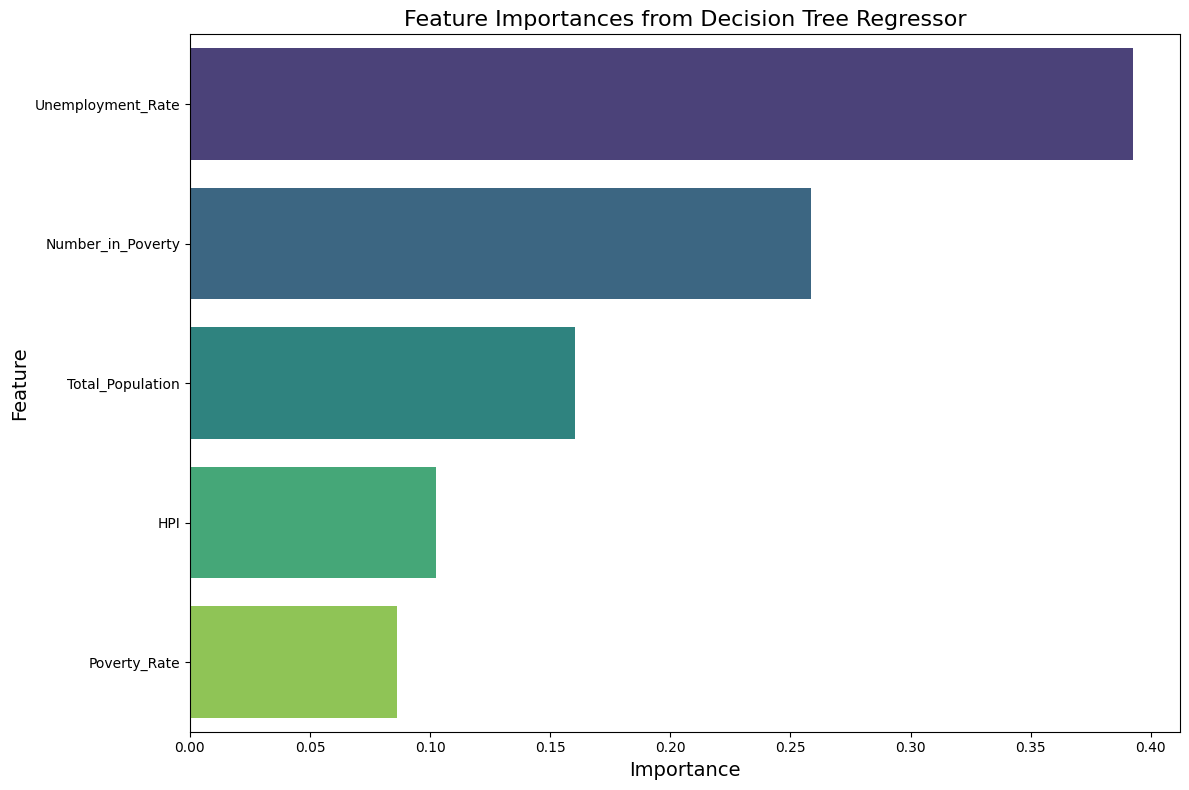

In [18]:
# ==============================================
# 14. Determine Feature Importance from Decision Tree
# ==============================================

# Get feature importances from the model
importances = dt_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("\nFeature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Decision Tree Regressor', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


Random Forest Regressor has been trained successfully!

Random Forest Regressor Performance:
Mean Squared Error (MSE): 5022413.27
R-squared: 0.1692

Random Forest Feature Importances:
             Feature  Importance
2   Total_Population    0.350062
0  Number_in_Poverty    0.254283
4  Unemployment_Rate    0.165945
3                HPI    0.119327
1       Poverty_Rate    0.110383


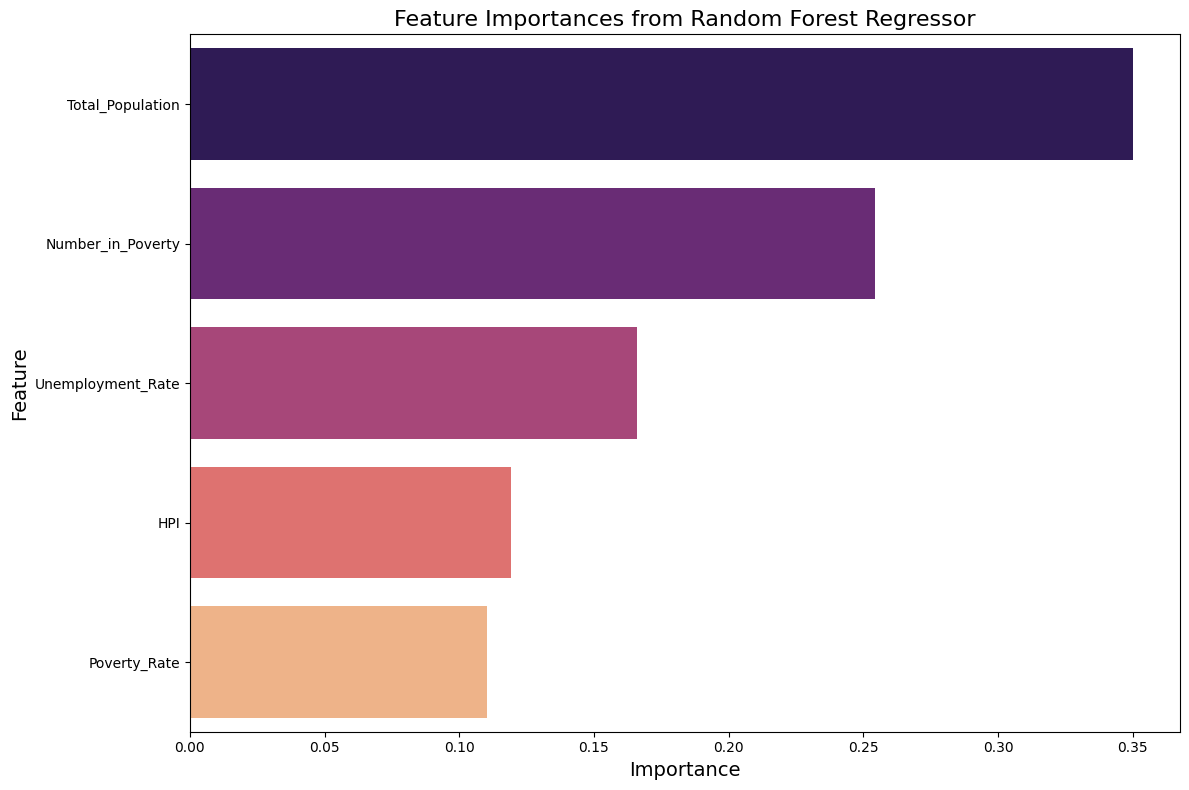

In [19]:
# ==============================================
# 15. Train and Evaluate a Random Forest Regressor
# ==============================================

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)
print("\nRandom Forest Regressor has been trained successfully!")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R-squared: {r2_rf:.4f}")

# Extract feature importances from the Random Forest model
importances_rf = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("\nRandom Forest Feature Importances:")
print(feature_importance_rf)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_rf, x='Importance', y='Feature', palette='magma')
plt.title('Feature Importances from Random Forest Regressor', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()



Starting Grid Search for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_es

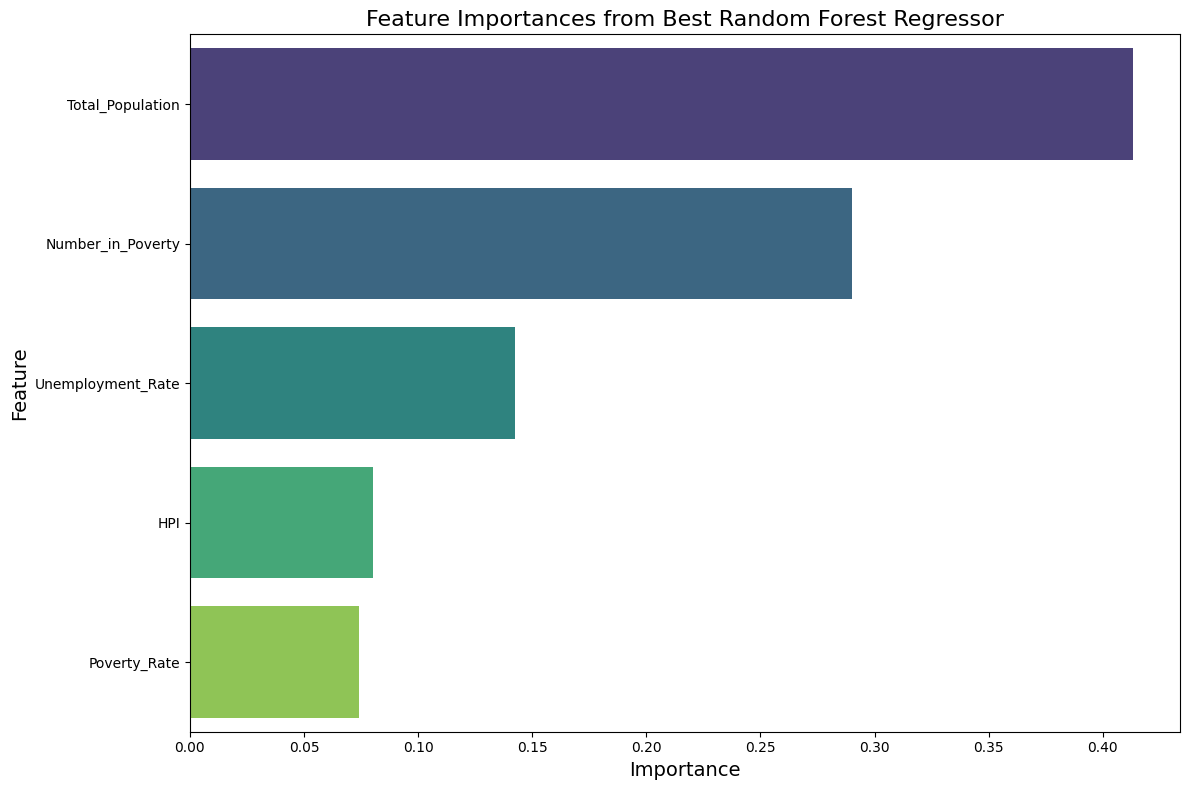

In [20]:
# ==============================================
# 16. Hyperparameter Tuning for Random Forest
# ==============================================

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
print("\nStarting Grid Search for Random Forest...")
grid_search_rf.fit(X_train, y_train)

# Best parameters
print("\nBest parameters found for Random Forest:")
print(grid_search_rf.best_params_)

# Best estimator
best_rf_model = grid_search_rf.best_estimator_

# Predict with the best model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"\nBest Random Forest Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse_best_rf:.2f}")
print(f"R-squared: {r2_best_rf:.4f}")

# Feature Importances from the best Random Forest model
importances_best_rf = best_rf_model.feature_importances_
feature_importance_best_rf = pd.DataFrame({
    'Feature': features,
    'Importance': importances_best_rf
}).sort_values(by='Importance', ascending=False)

print("\nBest Random Forest Feature Importances:")
print(feature_importance_best_rf)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_best_rf, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Best Random Forest Regressor', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
# ==============================================
# 17. Cross-Validation for Random Forest
# ==============================================

# Initialize the model with best parameters
rf_model_cv = RandomForestRegressor(
    n_estimators=best_rf_model.n_estimators,
    max_depth=best_rf_model.max_depth,
    min_samples_split=best_rf_model.min_samples_split,
    min_samples_leaf=best_rf_model.min_samples_leaf,
    random_state=42
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model_cv, X, y, cv=5, scoring='r2')

print("\nCross-Validation R-squared Scores:")
print(cv_scores)
print(f"Mean R-squared: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")


Cross-Validation R-squared Scores:
[-0.29415514 -1.14642968  0.17699864  0.26794702  0.27438956]
Mean R-squared: -0.1442
Standard Deviation: 0.5432


In [22]:
# ==============================================
# 18. Feature Engineering with Polynomial Features (Optional)
# ==============================================

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_features = poly.get_feature_names_out(features)
X_poly = pd.DataFrame(X_poly, columns=poly_features)

# Split the polynomial features
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train a new Random Forest model on polynomial features
rf_model_poly = RandomForestRegressor(
    n_estimators=best_rf_model.n_estimators,
    max_depth=best_rf_model.max_depth,
    min_samples_split=best_rf_model.min_samples_split,
    min_samples_leaf=best_rf_model.min_samples_leaf,
    random_state=42
)

rf_model_poly.fit(X_train_poly, y_train_poly)
y_pred_poly = rf_model_poly.predict(X_test_poly)

# Evaluate the new model
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)

print("\nRandom Forest Regressor with Polynomial Features Performance:")
print(f"Mean Squared Error (MSE): {mse_poly:.2f}")
print(f"R-squared: {r2_poly:.4f}")


Random Forest Regressor with Polynomial Features Performance:
Mean Squared Error (MSE): 5076845.21
R-squared: 0.1602



Gradient Boosting Regressor Performance:
Mean Squared Error (MSE): 4773147.68
R-squared: 0.2104

Gradient Boosting Feature Importances:
             Feature  Importance
0  Number_in_Poverty    0.290263
2   Total_Population    0.290033
4  Unemployment_Rate    0.238169
3                HPI    0.111142
1       Poverty_Rate    0.070392


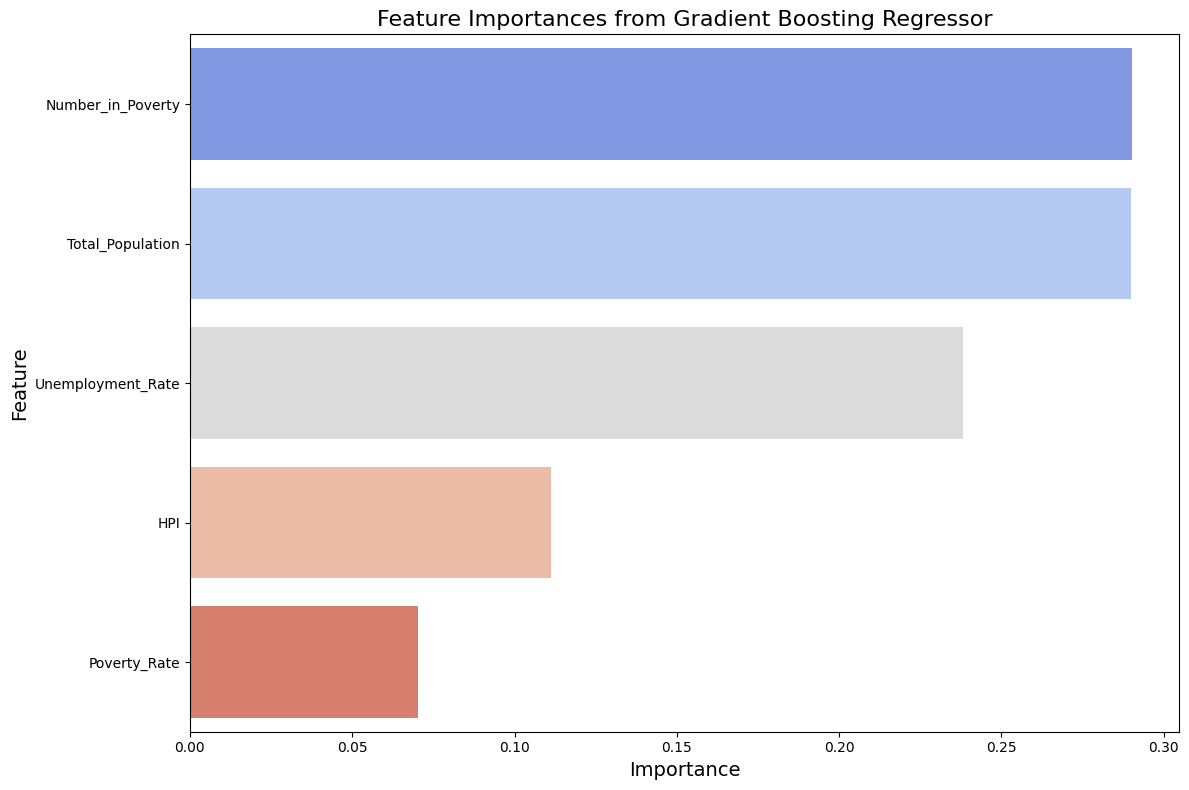

In [23]:
# ==============================================
# 19. Final Recommendations and Next Steps
# ==============================================

# Based on the performance metrics, consider further steps such as:
# - Feature Engineering (creating interaction terms, polynomial features)
# - Trying different models (e.g., Gradient Boosting, SVR, Neural Networks)
# - Handling outliers and skewed target distributions
# - Implementing feature selection techniques (e.g., Recursive Feature Elimination)

# Example: Training Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("\nGradient Boosting Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse_gb:.2f}")
print(f"R-squared: {r2_gb:.4f}")

# Feature Importances from Gradient Boosting
importances_gb = gb_model.feature_importances_
feature_importance_gb = pd.DataFrame({
    'Feature': features,
    'Importance': importances_gb
}).sort_values(by='Importance', ascending=False)

print("\nGradient Boosting Feature Importances:")
print(feature_importance_gb)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_gb, x='Importance', y='Feature', palette='coolwarm')
plt.title('Feature Importances from Gradient Boosting Regressor', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()